## Análise de Resultados da Otimização de Prompts
### Foco: Comparativo Zero-Shot e Few-Shot para Gemma e Sabiazinho (EVO vs. MOP)

Análise de Resultados da Otimização de Prompts

Este notebook tem como objetivo analisar os resultados dos experimentos de otimização de prompts, focando nas execuções:

| Tipo de Otimização | Abordagem | Gemma:2b | Sabiazinho-3 |
| :--- | :--- | :---: | :---: |
| **Mono-objetivo (EVO)** | zero-shot | ✓ | ✓ |
| | few-shot | ✓ | ✓ |
| **Multi-objetivo (MOP)** | zero-shot | ✓ | ✓ |
| | few-shot | ✓ | ✓ |

**Estrutura de Diretórios Esperada:**
- Notebook em: `mo-prompt-project/results/`
- Logs em: `mo-prompt-project/logs/`
- `BASE_LOG_PATH` = `../logs`

### 1. Configurações e dados

In [ ]:
%pip install datasets
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install numpy scipy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re 

In [4]:
# Configuração de Caminhos e Carregamento de Dados

BASE_LOG_PATH = "../logs"
STRATEGIES = ["zero-shot", "few-shot"] 

# Configuração para nomes de modelo
MODEL_CONFIG = {
    "gemma": {"path_name": "gemma", "file_part": "gemma_2b", "display_name": "Gemma"},
    "sabiazinho": {"path_name": "sabiazinho", "file_part": "sabiazinho_3", "display_name": "Sabiazinho"}
}

# Bloco de Verificação de Caminhos
print(f"Diretório de Trabalho Atual: {os.getcwd()}")
print(f"BASE_LOG_PATH configurado como: {BASE_LOG_PATH}")
absolute_base_log_path = os.path.abspath(BASE_LOG_PATH)
print(f"Caminho absoluto para logs: {absolute_base_log_path}")
if not os.path.isdir(absolute_base_log_path):
    print(f"!!!! ATENÇÃO: A pasta BASE_LOG_PATH ('{absolute_base_log_path}') não foi encontrada. !!!!")

# Função de Carregamento de Dados
def load_single_experiment_data(opt_type, model_key, strategy_param, data_type="final"):
    """
    Carrega e pré-processa dados de um único experimento.
    model_key: 'gemma' ou 'sabiazinho' (chaves do MODEL_CONFIG)
    strategy_param: 'zero-shot' ou 'few-shot'
    data_type: 'final' ou 'all_generations'.
    """
    if model_key not in MODEL_CONFIG:
        print(f"[load_data] ERRO: Chave de modelo '{model_key}' não encontrada em MODEL_CONFIG.")
        return pd.DataFrame()
        
    model_cfg = MODEL_CONFIG[model_key]
    model_path_name = model_cfg["path_name"]
    model_file_name_part = model_cfg["file_part"]
    model_display_name = model_cfg["display_name"]
    
    # O strategy_param é usado aqui para montar o caminho dinamicamente
    experiment_base_path = os.path.join(BASE_LOG_PATH, opt_type, model_path_name, strategy_param)
    
    df = pd.DataFrame()

    if not os.path.isdir(experiment_base_path):
        print(f"[load_data] ERRO: Diretório do experimento não encontrado: '{os.path.abspath(experiment_base_path)}'")
        return df

    if data_type == "final":
        file_path = os.path.join(experiment_base_path, "final_results.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Erro ao ler CSV '{file_path}': {e}")
        else:
            print(f"[load_data] Arquivo final não encontrado: {os.path.abspath(file_path)}")
            
    elif data_type == "all_generations":
        all_gen_dfs = []
        if opt_type == "evo":
            gen_detail_path = os.path.join(experiment_base_path, "generation_detail")
            if not os.path.isdir(gen_detail_path):
                print(f"[load_data] ERRO: Dir de detalhes da geração EVO não encontrado: '{os.path.abspath(gen_detail_path)}'")
                return df
            # O strategy_param é usado aqui para encontrar o arquivo correto
            pattern = os.path.join(gen_detail_path, f"results_gen_*_{model_file_name_part}_{strategy_param}.csv")
            file_list = glob.glob(pattern)
            if not file_list: print(f"[load_data] Nenhum arq de geração EVO: {pattern}")
            for f_path in file_list:
                try:
                    temp_df = pd.read_csv(f_path)
                    if 'generation' not in temp_df.columns:
                        fname = os.path.basename(f_path)
                        match = re.search(r"results_gen_(\d+)_", fname)
                        if match: temp_df['generation'] = int(match.group(1))
                    all_gen_dfs.append(temp_df)
                except Exception as e: print(f"Erro ao carregar {f_path}: {e}")
        elif opt_type == "mo":
            gen_pareto_path = os.path.join(experiment_base_path, "per_generation_pareto")
            if not os.path.isdir(gen_pareto_path):
                print(f"[load_data] ERRO: Dir de Pareto por geração MOP não encontrado: '{os.path.abspath(gen_pareto_path)}'")
                return df
            pattern = os.path.join(gen_pareto_path, "pareto_gen_*.csv")
            file_list = glob.glob(pattern)
            if not file_list: print(f"[load_data] Nenhum arq de geração MOP: {pattern}")
            for f_path in file_list:
                try:
                    temp_df = pd.read_csv(f_path)
                    fname = os.path.basename(f_path)
                    match = re.search(r"pareto_gen_(\d+)\.csv", fname)
                    if match: temp_df['generation'] = int(match.group(1))
                    all_gen_dfs.append(temp_df)
                except Exception as e: print(f"Erro ao carregar {f_path}: {e}")
        if all_gen_dfs: df = pd.concat(all_gen_dfs, ignore_index=True)
    
    if not df.empty:
        rename_map = {}
        if 'acc' in df.columns and 'accuracy' not in df.columns:
            rename_map['acc'] = 'accuracy'
        if 'f1' in df.columns and 'f1_score' not in df.columns:
            rename_map['f1'] = 'f1_score'
        if rename_map:
            df.rename(columns=rename_map, inplace=True)
        
        df['model'] = model_display_name
        # O strategy_param é usado aqui para criar a coluna de identificação
        df['strategy'] = strategy_param.replace('-', ' ').capitalize()
        df['optimization_type'] = opt_type.upper()
        df['run_id'] = f"{opt_type.upper()} {model_display_name} {df['strategy'].iloc[0]}"
        
    return df

# Defina todos os tipos de otimização que você deseja carregar
OPT_TYPES = ["evo", "mop"] 

all_final_data = []

# Itere sobre cada tipo de otimização, modelo e ESTRATÉGIA
print("\n--- INICIANDO CARREGAMENTO DE DADOS")
for opt_type in OPT_TYPES:
    for model_key in MODEL_CONFIG.keys():
        for strategy in STRATEGIES:
            print(f"Carregando: {opt_type.upper()} / {MODEL_CONFIG[model_key]['display_name']} / {strategy}")
            
            # Chama a função para cada combinação
            df_experiment = load_single_experiment_data(
                opt_type=opt_type,
                model_key=model_key,
                strategy_param=strategy,
                data_type="final" # ou "all_generations"
            )
            
            if not df_experiment.empty:
                all_final_data.append(df_experiment)

# Concatene todos os dataframes em um único dataframe mestre
if all_final_data:
    master_df = pd.concat(all_final_data, ignore_index=True)
    print("\n--- CARREGAMENTO CONCLUÍDO")
    print("DataFrame mestre criado com sucesso!")
    print(f"Total de linhas carregadas: {len(master_df)}")
    # Mostra um resumo das combinações carregadas
    print("\nCombinações carregadas (run_id):")
    print(master_df['run_id'].value_counts())
else:
    print("\nNenhum dado foi carregado.")
    master_df = pd.DataFrame() # Cria um dataframe vazio para evitar erros


Diretório de Trabalho Atual: /home/sara/repos/mo-prompt-project/results
BASE_LOG_PATH configurado como: ../logs
Caminho absoluto para logs: /home/sara/repos/mo-prompt-project/logs

--- INICIANDO CARREGAMENTO DE DADOS
Carregando: EVO / Gemma / zero-shot
Carregando: EVO / Gemma / few-shot
Carregando: EVO / Sabiazinho / zero-shot
Carregando: EVO / Sabiazinho / few-shot
Carregando: MOP / Gemma / zero-shot
[load_data] ERRO: Diretório do experimento não encontrado: '/home/sara/repos/mo-prompt-project/logs/mop/gemma/zero-shot'
Carregando: MOP / Gemma / few-shot
[load_data] ERRO: Diretório do experimento não encontrado: '/home/sara/repos/mo-prompt-project/logs/mop/gemma/few-shot'
Carregando: MOP / Sabiazinho / zero-shot
[load_data] ERRO: Diretório do experimento não encontrado: '/home/sara/repos/mo-prompt-project/logs/mop/sabiazinho/zero-shot'
Carregando: MOP / Sabiazinho / few-shot
[load_data] ERRO: Diretório do experimento não encontrado: '/home/sara/repos/mo-prompt-project/logs/mop/sabiazin

In [5]:
# ### Carregar Dados Finais de Todos os Experimentos

# Definir os parâmetros para gerar as combinações
OPT_TYPES = ["evo", "mop"]
STRATEGIES = ["zero-shot", "few-shot"]
# MODEL_CONFIG também já deve existir

# Lista de experimentos dinamica
focused_experiments = [
    (opt, model, strat)
    for opt in OPT_TYPES
    for model in MODEL_CONFIG.keys()
    for strat in STRATEGIES
]

final_data_map = {}
all_final_data_list = []

print(" INICIANDO CARREGAMENTO DOS DADOS FINAIS ")
for opt_type, model_key, strategy_param in focused_experiments:
    # A chave para o dicionário agora inclui a estratégia de forma explícita
    run_label = f"{opt_type}_{model_key}_{strategy_param.replace('-', '_')}"
    
    print(f"Carregando: {opt_type.upper()} - {MODEL_CONFIG[model_key]['display_name']} - {strategy_param}")
    
    df_final = load_single_experiment_data(opt_type, model_key, strategy_param, data_type="final")
    
    final_data_map[run_label] = df_final
    
    if not df_final.empty:
        all_final_data_list.append(df_final)
    else:
        print(f"  -> ATENÇÃO: Dados não carregados ou vazios para '{run_label}'.")

# Concatenação e verificação
if all_final_data_list:
    df_all_final_results = pd.concat(all_final_data_list, ignore_index=True)
    print(f"\nDataFrame Mestre 'df_all_final_results' criado com shape: {df_all_final_results.shape}")
    
    # Este groupby agora mostrará todas as combinações carregadas
    print("\nResumo dos dados carregados:")
    print(df_all_final_results.groupby(['optimization_type', 'model', 'strategy']).size().reset_index(name='count'))
else:
    print("\nNenhum dado final foi carregado. Verifique os caminhos e logs.")
    df_all_final_results = pd.DataFrame()


print("\n ACESSO RÁPIDO AOS DATAFRAMES (Exemplos) ")

# Exemplo de como pegar dataframes específicos do dicionário:
evo_gemma_zero_shot_df = final_data_map.get("evo_gemma_zero_shot", pd.DataFrame())
evo_gemma_few_shot_df  = final_data_map.get("evo_gemma_few_shot", pd.DataFrame())

evo_sabiazinho_zero_shot_df = final_data_map.get("evo_sabiazinho_zero_shot", pd.DataFrame())
evo_sabiazinho_few_shot_df  = final_data_map.get("evo_sabiazinho_few_shot", pd.DataFrame())

mop_gemma_zero_shot_df = final_data_map.get("mop_gemma_zero_shot", pd.DataFrame())
mop_gemma_few_shot_df = final_data_map.get("mop_gemma_few_shot", pd.DataFrame())

mop_sabiazinho_zero_shot_df = final_data_map.get("mop_sabiazinho_zero_shot", pd.DataFrame())
mop_sabiazinho_few_shot_df  = final_data_map.get("mop_sabiazinho_few_shot", pd.DataFrame())

# Variáveis para análises específicas
print("\nVerificando um dataframe carregado (Evo Gemma Zero-shot):")
if not evo_gemma_zero_shot_df.empty:
    print(f"Shape: {evo_gemma_zero_shot_df.shape}")
    print(evo_gemma_zero_shot_df.head(2)) # Descomente para ver o conteúdo
else:
    print(" -> DataFrame 'evo_gemma_zero_shot' está vazio.")

 INICIANDO CARREGAMENTO DOS DADOS FINAIS 
Carregando: EVO - Gemma - zero-shot
Carregando: EVO - Gemma - few-shot
Carregando: EVO - Sabiazinho - zero-shot
Carregando: EVO - Sabiazinho - few-shot
Carregando: MOP - Gemma - zero-shot
Carregando: MOP - Gemma - few-shot
Carregando: MOP - Sabiazinho - zero-shot
Carregando: MOP - Sabiazinho - few-shot

DataFrame Mestre 'df_all_final_results' criado com shape: (54, 11)

Resumo dos dados carregados:
  optimization_type       model   strategy  count
0               EVO       Gemma   Few shot     10
1               EVO       Gemma  Zero shot     10
2               EVO  Sabiazinho   Few shot     10
3               EVO  Sabiazinho  Zero shot     10
4               MOP       Gemma   Few shot      3
5               MOP       Gemma  Zero shot      2
6               MOP  Sabiazinho   Few shot      3
7               MOP  Sabiazinho  Zero shot      6

 ACESSO RÁPIDO AOS DATAFRAMES (Exemplos) 

Verificando um dataframe carregado (Evo Gemma Zero-shot):
Shap

### 2. Tabela Resumo de Desempenho
Destaca os principais resultados de cada uma das 6 configurações experimentais

In [6]:
summary_list = []

if not df_all_final_results.empty:
    # Iterar sobre os grupos únicos de 'run_id' para extrair os pontos corretos
    for run_id, group_df in df_all_final_results.groupby('run_id'):
        if group_df.empty:
            print(f"Grupo {run_id} está vazio, pulando.")
            continue
            
        model = group_df['model'].iloc[0]
        strategy = group_df['strategy'].iloc[0]
        opt_type = group_df['optimization_type'].iloc[0]

        # Padronizar nomes das colunas de métricas para acesso
        acc_col = 'accuracy' if 'accuracy' in group_df.columns else None
        tok_col = 'tokens' if 'tokens' in group_df.columns else None
        f1_col = 'f1_score' if 'f1_score' in group_df.columns else None

        if not acc_col or not tok_col:
            print(f"ERRO: Colunas de acurácia ou tokens não encontradas para {run_id}. Colunas: {group_df.columns.tolist()}")
            continue

        if opt_type == "EVO":
            best_evo = group_df.sort_values(by=[acc_col, tok_col], ascending=[False, True]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Melhor Acurácia',
                'Acurácia': best_evo[acc_col],
                'Tokens': int(best_evo[tok_col]),
                'F1-Score': best_evo.get(f1_col, np.nan) if f1_col else np.nan
            })
        elif opt_type == "MOP":
            # Ponto de Maior Acurácia na Fronteira
            max_acc_mop = group_df.sort_values(by=[acc_col, tok_col], ascending=[False, True]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Max Acc (Fronteira)',
                'Acurácia': max_acc_mop[acc_col],
                'Tokens': int(max_acc_mop[tok_col]),
                'F1-Score': max_acc_mop.get(f1_col, np.nan) if f1_col else np.nan
            })
            # Ponto de Menor Tokens na Fronteira
            min_tok_mop = group_df.sort_values(by=[tok_col, acc_col], ascending=[True, False]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Min Tokens (Fronteira)',
                'Acurácia': min_tok_mop[acc_col],
                'Tokens': int(min_tok_mop[tok_col]),
                'F1-Score': min_tok_mop.get(f1_col, np.nan) if f1_col else np.nan
            })
else:
    print("DataFrame df_all_final_results está vazio. Não é possível gerar tabela resumo.")

if summary_list:
    df_summary = pd.DataFrame(summary_list)
    print("\n--- Tabela Resumo de Desempenho ---")
    
    float_format_cols = ['Acurácia', 'F1-Score']
    for col in float_format_cols:
        if col in df_summary.columns:
            df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce').map('{:.4f}'.format)
    
    df_summary_sorted = df_summary.sort_values(by=['Modelo', 'Estratégia', 'Otimização', 'Destaque'])
    print(df_summary_sorted[['Modelo', 'Estratégia', 'Otimização', 'Destaque', 'Acurácia', 'Tokens', 'F1-Score']].to_string(index=False))
else:
    print("Não foi possível gerar a tabela resumo.")



--- Tabela Resumo de Desempenho ---
    Modelo Estratégia Otimização               Destaque Acurácia  Tokens F1-Score
     Gemma   Few shot        EVO        Melhor Acurácia   0.8200      20   0.8163
     Gemma   Few shot        MOP    Max Acc (Fronteira)   0.8100      13   0.8041
     Gemma   Few shot        MOP Min Tokens (Fronteira)   0.7600      10   0.7551
     Gemma  Zero shot        EVO        Melhor Acurácia   0.8700      19   0.8632
     Gemma  Zero shot        MOP    Max Acc (Fronteira)   0.8500      12   0.8315
     Gemma  Zero shot        MOP Min Tokens (Fronteira)   0.7900      10   0.7407
Sabiazinho   Few shot        EVO        Melhor Acurácia   0.9700      16   0.9703
Sabiazinho   Few shot        MOP    Max Acc (Fronteira)   0.9700      11   0.9703
Sabiazinho   Few shot        MOP Min Tokens (Fronteira)   0.9600      10   0.9600
Sabiazinho  Zero shot        EVO        Melhor Acurácia   0.9600      18   0.9600
Sabiazinho  Zero shot        MOP    Max Acc (Fronteira)   0.9

**Discussão da Tabela Resumo (para o artigo):**
* Qual modelo (Gemma/Sabia) e tipo de otimização (EVO/MOP) alcançou a maior acurácia?
* Para MOP, qual foi o menor número de tokens alcançado com uma acurácia ainda competitiva?
* Como se comparam os "melhores" pontos do EVO com os pontos extrmops (max acc, min tokens) do MOP para o mesmo modelo?

--------------------------------------------------------------------------------------------------------------------------

**Comparativo de Desempenho: EVO vs. MOP**

A comparação direta entre a melhor solução do EVO e os pontos extrmops do MOP para um mesmo modelo e estratégia é particularmente elucidativa sobre os benefícios da otimização multi-objetivo:

 * Para o Sabiazinho (Few-shot): O EVO encontrou uma solução com 0.9700 de acurácia usando 16 tokens. O MOP também encontrou uma solução com a mesma acurácia de 0.9700, porém utilizando apenas 11 tokens – uma economia de mais de 30%. Isso mostra que a busca focada apenas em acurácia (EVO) pode levar a soluções eficientes, mas não necessariamente às mais eficientes possíveis. O MOP foi capaz de identificar uma alternativa superior ao considerar dois objetivos simultaneamente.

 * Para o Gemma (Zero-shot): O EVO alcançou a maior acurácia para este modelo (0.8700), mas com um custo de 19 tokens. Em contrapartida, o ponto de "Máxima Acurácia" do MOP atingiu uma performance muito próxima (0.8500), utilizando apenas 12 tokens. Neste caso, o MOP oferece uma alternativa que sacrifica apenas 0.02 ponto de acurácia para economizar 7 tokens (~37% de redução). Para muitas aplicações práticas, esta seria uma troca altamente desejável.


### 3. Comparativo Visual: Melhor Ponto EVO vs. Fronteira MOP (por Modelo)


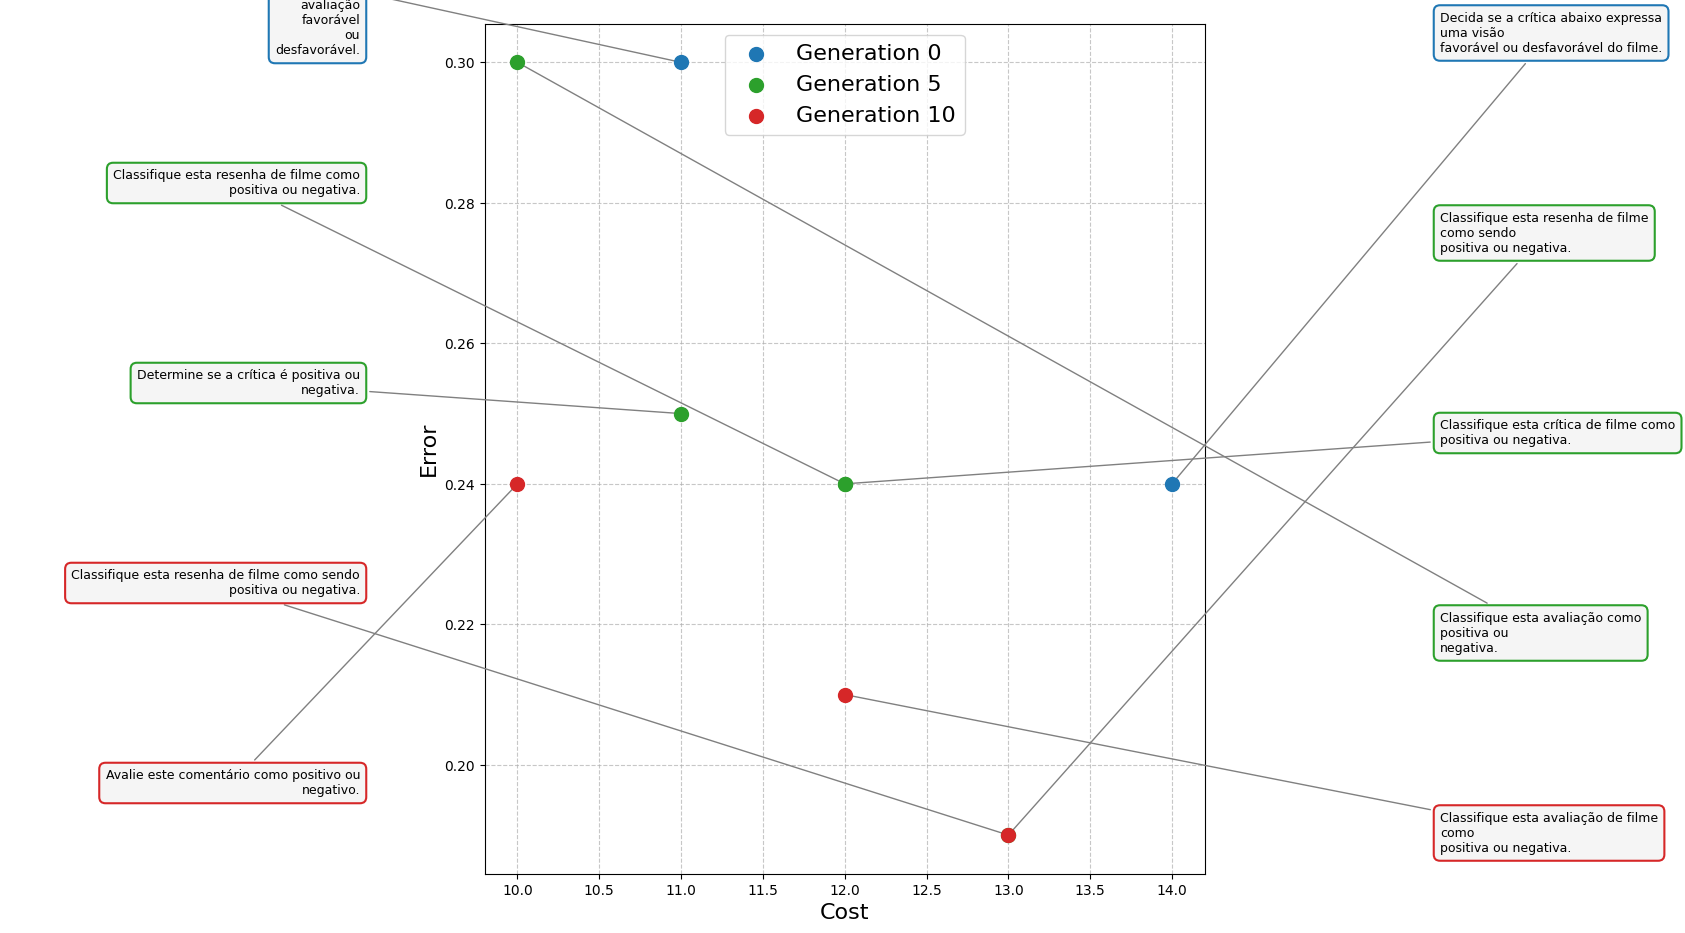

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import matplotlib.patheffects as path_effects
import textwrap # <-- 1. Importamos a biblioteca para formatar o texto

# Dados fornecidos pelo usuário
csv_data = """generation,prompt,acc,f1,tokens,rank,crowding_distance
0,Decida se a crítica abaixo expressa uma visão favorável ou desfavorável do filme.,0.76,0.7073170731707317,14,0,inf
0,Determine se a crítica expressa uma avaliação favorável ou desfavorável.,0.7,0.7580645161290323,11,0,inf
5,"Classifique esta resenha de filme como sendo positiva ou negativa.",0.81,0.8041237113402062,13,0,inf
5,"Classifique esta resenha de filme como positiva ou negativa.",0.76,0.75,12,0,0.4242424242424242
5,"Classifique esta crítica de filme como positiva ou negativa.",0.76,0.7333333333333333,12,0,0.7878787878787878
5,"Determine se a crítica é positiva ou negativa.",0.75,0.7619047619047619,11,0,1.212121212121212
5,"Classifique esta avaliação como positiva ou negativa.",0.7,0.7272727272727273,10,0,inf
10,"Classifique esta resenha de filme como sendo positiva ou negativa.",0.81,0.8041237113402062,13,0,inf
10,"Classifique esta avaliação de filme como positiva ou negativa.",0.79,0.7878787878787878,12,0,2.0
10,"Avalie este comentário como positivo ou negativo.",0.76,0.7551020408163265,10,0,inf
"""

# Criar um DataFrame a partir dos dados
gemma_few_shot_df = pd.read_csv(io.StringIO(csv_data))

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(18, 10))

# --- Paleta de cores para as gerações ---
cores_geracoes = {0: '#1f77b4', 5: '#2ca02c', 10: '#d62728'}

# --- Lógica de Posicionamento Lateral ---
prompts_direita = [p for i, p in enumerate(gemma_few_shot_df.itertuples()) if i % 2 == 0]
prompts_esquerda = [p for i, p in enumerate(gemma_few_shot_df.itertuples()) if i % 2 != 0]
pos_y_direita = np.linspace(0.9, 0.1, len(prompts_direita))
pos_y_esquerda = np.linspace(0.95, 0.15, len(prompts_esquerda))

# --- Adicionando as Anotações ---

# Plota todos os pontos de dados primeiro
for index, row in gemma_few_shot_df.iterrows():
    cor = cores_geracoes.get(row['generation'], 'gray')
    ax.scatter(row['tokens'], 1 - row['acc'], color=cor, s=100, zorder=5,
               label=f"Generation {row['generation']}")

# Anotações da Direita
for i, ponto in enumerate(prompts_direita):
    # 2. Formata o texto para ter uma largura maior
    texto_formatado = textwrap.fill(ponto.prompt, width=45)
    
    ax.annotate(
        text=texto_formatado,
        xy=(ponto.tokens, 1 - ponto.acc),
        xytext=(0.80, pos_y_direita[i]), # <-- Caixas mais próximas
        textcoords='figure fraction',
        # 3. Seta reta (rmopvido o 'connectionstyle')
        arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
        bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
        fontsize=9, wrap=True, ha='left', va='center'
    )

# Anotações da Esquerda
for i, ponto in enumerate(prompts_esquerda):
    # 2. Formata o texto para ter uma largura maior
    texto_formatado = textwrap.fill(ponto.prompt, width=45)

    ax.annotate(
        text=texto_formatado,
        xy=(ponto.tokens, 1 - ponto.acc),
        xytext=(0.20, pos_y_esquerda[i]), # <-- Caixas mais próximas
        textcoords='figure fraction',
        # 3. Seta reta (rmopvido o 'connectionstyle')
        arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
        bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
        fontsize=9, wrap=True, ha='right', va='center'
    )


# --- Configurações Finais ---
ax.set_xlabel("Cost", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)

# Lógica para legenda sem duplicatas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="", fontsize=16, loc='best')

# Ajusta o espaçamento da figura para dar espaço às anotações
plt.subplots_adjust(left=0.3, right=0.7, top=0.95, bottom=0.1)

plt.show()

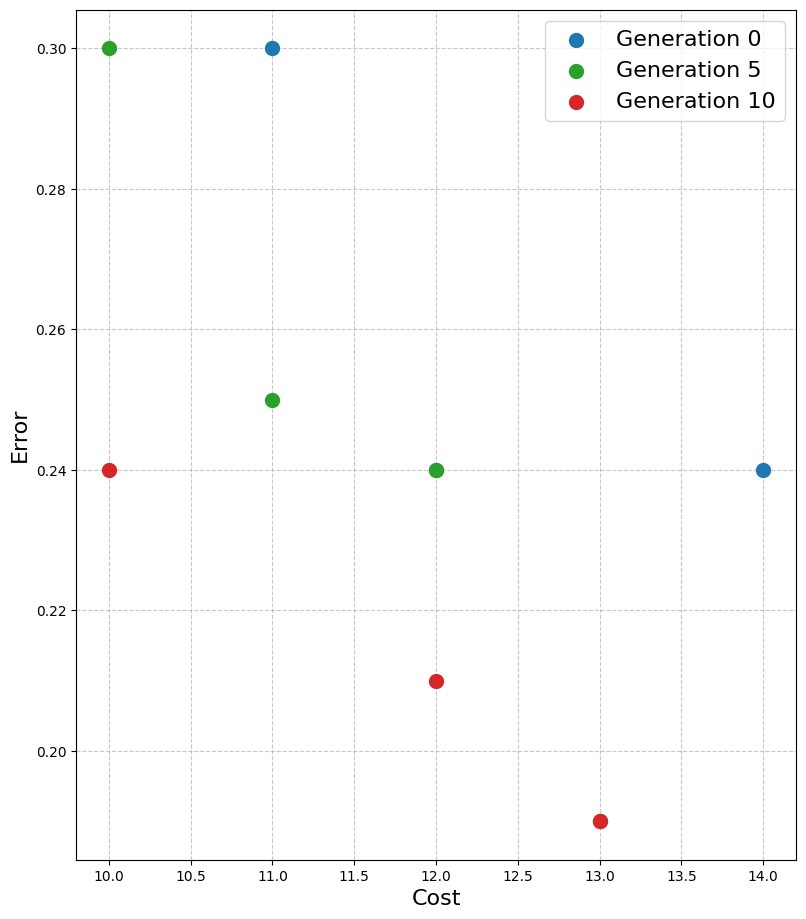

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import matplotlib.patheffects as path_effects
import textwrap # <-- 1. Importamos a biblioteca para formatar o texto

# Dados fornecidos pelo usuário
csv_data = """generation,prompt,acc,f1,tokens,rank,crowding_distance
0,Decida se a crítica abaixo expressa uma visão favorável ou desfavorável do filme.,0.76,0.7073170731707317,14,0,inf
0,Determine se a crítica expressa uma avaliação favorável ou desfavorável.,0.7,0.7580645161290323,11,0,inf
5,"Classifique esta resenha de filme como sendo positiva ou negativa.",0.81,0.8041237113402062,13,0,inf
5,"Classifique esta resenha de filme como positiva ou negativa.",0.76,0.75,12,0,0.4242424242424242
5,"Classifique esta crítica de filme como positiva ou negativa.",0.76,0.7333333333333333,12,0,0.7878787878787878
5,"Determine se a crítica é positiva ou negativa.",0.75,0.7619047619047619,11,0,1.212121212121212
5,"Classifique esta avaliação como positiva ou negativa.",0.7,0.7272727272727273,10,0,inf
10,"Classifique esta resenha de filme como sendo positiva ou negativa.",0.81,0.8041237113402062,13,0,inf
10,"Classifique esta avaliação de filme como positiva ou negativa.",0.79,0.7878787878787878,12,0,2.0
10,"Avalie este comentário como positivo ou negativo.",0.76,0.7551020408163265,10,0,inf
"""

# Criar um DataFrame a partir dos dados
gemma_few_shot_df = pd.read_csv(io.StringIO(csv_data))

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(18, 10))

# --- Paleta de cores para as gerações ---
cores_geracoes = {0: '#1f77b4', 5: '#2ca02c', 10: '#d62728'}

# --- Lógica de Posicionamento Lateral ---
prompts_direita = [p for i, p in enumerate(gemma_few_shot_df.itertuples()) if i % 2 == 0]
prompts_esquerda = [p for i, p in enumerate(gemma_few_shot_df.itertuples()) if i % 2 != 0]
pos_y_direita = np.linspace(0.9, 0.1, len(prompts_direita))
pos_y_esquerda = np.linspace(0.95, 0.15, len(prompts_esquerda))

# --- Adicionando as Anotações ---

# Plota todos os pontos de dados primeiro
for index, row in gemma_few_shot_df.iterrows():
    cor = cores_geracoes.get(row['generation'], 'gray')
    ax.scatter(row['tokens'], 1 - row['acc'], color=cor, s=100, zorder=5,
               label=f"Generation {row['generation']}")

# # Anotações da Direita
# for i, ponto in enumerate(prompts_direita):
#     # 2. Formata o texto para ter uma largura maior
#     texto_formatado = textwrap.fill(ponto.prompt, width=45)
    
#     ax.annotate(
#         text=texto_formatado,
#         xy=(ponto.tokens, 1 - ponto.acc),
#         xytext=(0.80, pos_y_direita[i]), # <-- Caixas mais próximas
#         textcoords='figure fraction',
#         # 3. Seta reta (rmopvido o 'connectionstyle')
#         arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
#         bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
#         fontsize=9, wrap=True, ha='left', va='center'
#     )

# # Anotações da Esquerda
# for i, ponto in enumerate(prompts_esquerda):
#     # 2. Formata o texto para ter uma largura maior
#     texto_formatado = textwrap.fill(ponto.prompt, width=45)

#     ax.annotate(
#         text=texto_formatado,
#         xy=(ponto.tokens, 1 - ponto.acc),
#         xytext=(0.20, pos_y_esquerda[i]), # <-- Caixas mais próximas
#         textcoords='figure fraction',
#         # 3. Seta reta (rmopvido o 'connectionstyle')
#         arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
#         bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
#         fontsize=9, wrap=True, ha='right', va='center'
#     )


# --- Configurações Finais ---
ax.set_xlabel("Cost", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)

# Lógica para legenda sem duplicatas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="", fontsize=16, loc='best')

# Ajusta o espaçamento da figura para dar espaço às anotações
plt.subplots_adjust(left=0.3, right=0.7, top=0.95, bottom=0.1)

plt.show()

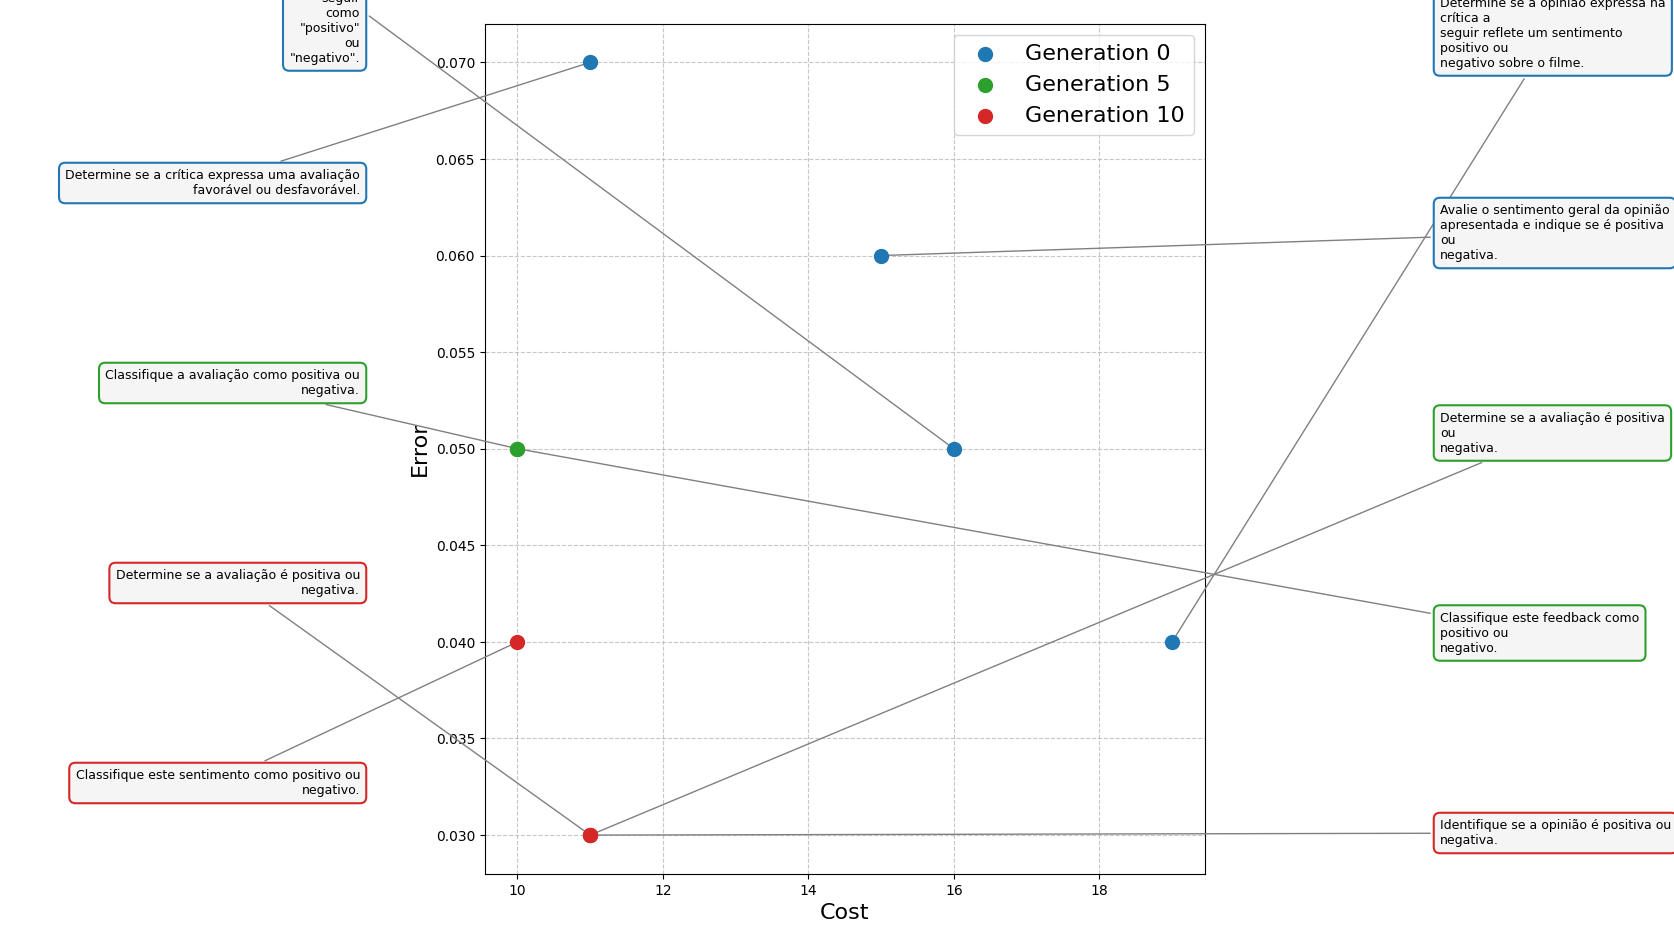

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import matplotlib.patheffects as path_effects
import textwrap # <-- 1. Importamos a biblioteca para formatar o texto

# Dados fornecidos pelo usuário
csv_data = """generation,prompt,acc,f1,tokens,rank,crowding_distance
0,"Determine se a opinião expressa na crítica a seguir reflete um sentimento positivo ou negativo sobre o filme.",0.96,0.96,19,0,inf
0,"Classifique o sentimento do texto a seguir como ""positivo"" ou ""negativo"".",0.95,0.9494949494949496,16,0,1.1666666666666692
0,"Avalie o sentimento geral da opinião apresentada e indique se é positiva ou negativa.",0.94,0.9411764705882352,15,0,1.2916666666666654
0,"Determine se a crítica expressa uma avaliação favorável ou desfavorável.",0.93,0.9320388349514565,11,0,inf
5,"Determine se a avaliação é positiva ou negativa.",0.97,0.9702970297029704,11,0,inf
5,"Classifique a avaliação como positiva ou negativa.",0.95,0.9504950495049505,10,0,inf
5,"Classifique este feedback como positivo ou negativo.",0.95,0.9514563106796116,10,0,2.0
10,"Determine se a avaliação é positiva ou negativa.",0.97,0.9702970297029704,11,0,2.0
10,"Identifique se a opinião é positiva ou negativa.",0.97,0.970873786407767,11,0,inf
10,"Classifique este sentimento como positivo ou negativo.",0.96,0.96,10,0,inf
"""

# Criar um DataFrame a partir dos dados
sabiazinho_few_shot_df = pd.read_csv(io.StringIO(csv_data))

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(18, 10))

# --- Paleta de cores para as gerações ---
cores_geracoes = {0: '#1f77b4', 5: '#2ca02c', 10: '#d62728'}

# --- Lógica de Posicionamento Lateral ---
prompts_direita = [p for i, p in enumerate(sabiazinho_few_shot_df.itertuples()) if i % 2 == 0]
prompts_esquerda = [p for i, p in enumerate(sabiazinho_few_shot_df.itertuples()) if i % 2 != 0]
pos_y_direita = np.linspace(0.9, 0.1, len(prompts_direita))
pos_y_esquerda = np.linspace(0.95, 0.15, len(prompts_esquerda))

# --- Adicionando as Anotações ---

# Plota todos os pontos de dados primeiro
for index, row in sabiazinho_few_shot_df.iterrows():
    cor = cores_geracoes.get(row['generation'], 'gray')
    ax.scatter(row['tokens'], 1 - row['acc'], color=cor, s=100, zorder=5,
               label=f"Generation {row['generation']}")

# Anotações da Direita
for i, ponto in enumerate(prompts_direita):
    # 2. Formata o texto para ter uma largura maior
    texto_formatado = textwrap.fill(ponto.prompt, width=45)
    
    ax.annotate(
        text=texto_formatado,
        xy=(ponto.tokens, 1 - ponto.acc),
        xytext=(0.80, pos_y_direita[i]), # <-- Caixas mais próximas
        textcoords='figure fraction',
        # 3. Seta reta (rmopvido o 'connectionstyle')
        arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
        bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
        fontsize=9, wrap=True, ha='left', va='center'
    )

# Anotações da Esquerda
for i, ponto in enumerate(prompts_esquerda):
    # 2. Formata o texto para ter uma largura maior
    texto_formatado = textwrap.fill(ponto.prompt, width=45)

    ax.annotate(
        text=texto_formatado,
        xy=(ponto.tokens, 1 - ponto.acc),
        xytext=(0.20, pos_y_esquerda[i]), # <-- Caixas mais próximas
        textcoords='figure fraction',
        # 3. Seta reta (rmopvido o 'connectionstyle')
        arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
        bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
        fontsize=9, wrap=True, ha='right', va='center'
    )


# --- Configurações Finais ---
ax.set_xlabel("Cost", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)

# Lógica para legenda sem duplicatas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="", fontsize=16, loc='best')

# Ajusta o espaçamento da figura para dar espaço às anotações
plt.subplots_adjust(left=0.3, right=0.7, top=0.95, bottom=0.1)

plt.show()

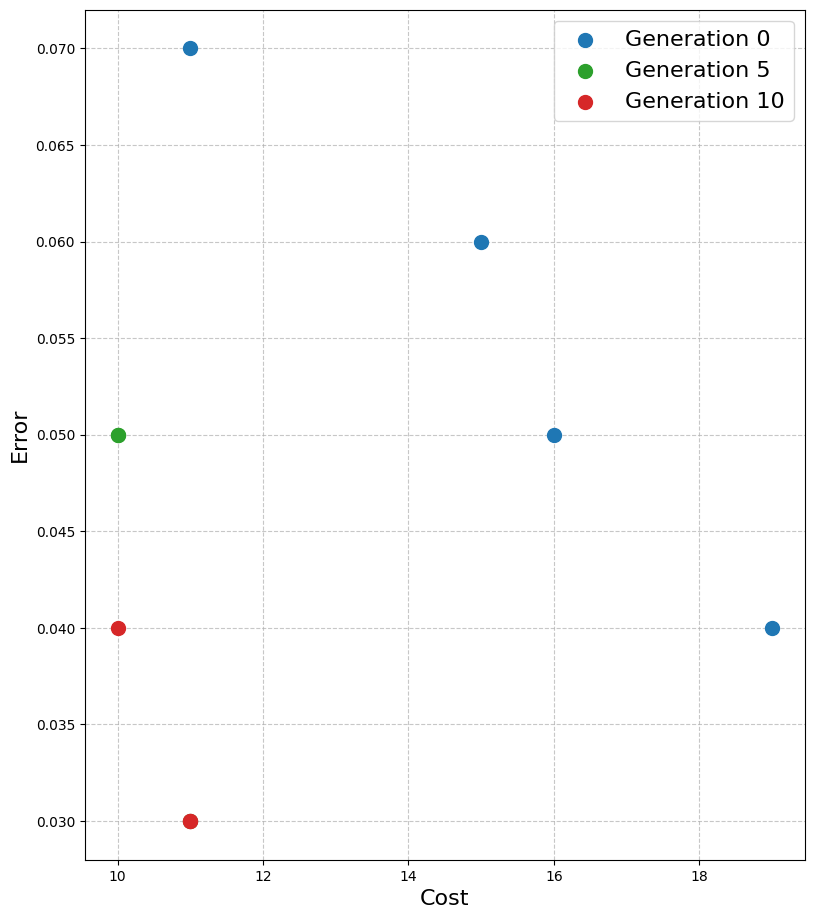

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import matplotlib.patheffects as path_effects
import textwrap # <-- 1. Importamos a biblioteca para formatar o texto

# Dados fornecidos pelo usuário
csv_data = """generation,prompt,acc,f1,tokens,rank,crowding_distance
0,"Determine se a opinião expressa na crítica a seguir reflete um sentimento positivo ou negativo sobre o filme.",0.96,0.96,19,0,inf
0,"Classifique o sentimento do texto a seguir como ""positivo"" ou ""negativo"".",0.95,0.9494949494949496,16,0,1.1666666666666692
0,"Avalie o sentimento geral da opinião apresentada e indique se é positiva ou negativa.",0.94,0.9411764705882352,15,0,1.2916666666666654
0,"Determine se a crítica expressa uma avaliação favorável ou desfavorável.",0.93,0.9320388349514565,11,0,inf
5,"Determine se a avaliação é positiva ou negativa.",0.97,0.9702970297029704,11,0,inf
5,"Classifique a avaliação como positiva ou negativa.",0.95,0.9504950495049505,10,0,inf
5,"Classifique este feedback como positivo ou negativo.",0.95,0.9514563106796116,10,0,2.0
10,"Determine se a avaliação é positiva ou negativa.",0.97,0.9702970297029704,11,0,2.0
10,"Identifique se a opinião é positiva ou negativa.",0.97,0.970873786407767,11,0,inf
10,"Classifique este sentimento como positivo ou negativo.",0.96,0.96,10,0,inf
"""

# Criar um DataFrame a partir dos dados
sabiazinho_few_shot_df = pd.read_csv(io.StringIO(csv_data))

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(18, 10))

# --- Paleta de cores para as gerações ---
cores_geracoes = {0: '#1f77b4', 5: '#2ca02c', 10: '#d62728'}

# --- Lógica de Posicionamento Lateral ---
prompts_direita = [p for i, p in enumerate(sabiazinho_few_shot_df.itertuples()) if i % 2 == 0]
prompts_esquerda = [p for i, p in enumerate(sabiazinho_few_shot_df.itertuples()) if i % 2 != 0]
pos_y_direita = np.linspace(0.9, 0.1, len(prompts_direita))
pos_y_esquerda = np.linspace(0.95, 0.15, len(prompts_esquerda))

# --- Adicionando as Anotações ---

# Plota todos os pontos de dados primeiro
for index, row in sabiazinho_few_shot_df.iterrows():
    cor = cores_geracoes.get(row['generation'], 'gray')
    ax.scatter(row['tokens'], 1 - row['acc'], color=cor, s=100, zorder=5,
            label=f"Generation {row['generation']}")

# # Anotações da Direita
# for i, ponto in enumerate(prompts_direita):
#     # 2. Formata o texto para ter uma largura maior
#     texto_formatado = textwrap.fill(ponto.prompt, width=45)
    
#     ax.annotate(
#         text=texto_formatado,
#         xy=(ponto.tokens, 1 - ponto.acc),
#         xytext=(0.80, pos_y_direita[i]), # <-- Caixas mais próximas
#         textcoords='figure fraction',
#         # 3. Seta reta (rmopvido o 'connectionstyle')
#         arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
#         bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
#         fontsize=9, wrap=True, ha='left', va='center'
#     )

# # Anotações da Esquerda
# for i, ponto in enumerate(prompts_esquerda):
#     # 2. Formata o texto para ter uma largura maior
#     texto_formatado = textwrap.fill(ponto.prompt, width=45)

#     ax.annotate(
#         text=texto_formatado,
#         xy=(ponto.tokens, 1 - ponto.acc),
#         xytext=(0.20, pos_y_esquerda[i]), # <-- Caixas mais próximas
#         textcoords='figure fraction',
#         # 3. Seta reta (rmopvido o 'connectionstyle')
#         arrowprops=dict(arrowstyle="-", color='gray', shrinkB=5),
#         bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec=cores_geracoes.get(ponto.generation, 'gray'), lw=1.5),
#         fontsize=9, wrap=True, ha='right', va='center'
#     )


# --- Configurações Finais ---
ax.set_xlabel("Cost", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)

# Lógica para legenda sem duplicatas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="", fontsize=16, loc='best')

# Ajusta o espaçamento da figura para dar espaço às anotações
plt.subplots_adjust(left=0.3, right=0.7, top=0.95, bottom=0.1)

plt.show()

**Discussão do Gráfico Combinado EVO vs. MOP (para o artigo):**
* Para cada modelo, a abordagem MOP encontrou soluções que dominam o melhor resultado EVO? (i.e., pontos MOP "acima e à esquerda" do ponto EVO).
* O MOP oferece alternativas significativamente mais eficientes em tokens para uma acurácia similar à do melhor EVO?
* Há diferenças marcantes entre Gemma e Sabiazinho neste comparativo?


----------------------------------------------------------------------------------------------------

**Alternativas Eficientes para Desempenho Máximo**

As distinções entre os dois modelos são evidentes e consistentes através das estratégias:

* Nível de Performance: Há um claro degrau de desempenho entre os modelos. As fronteiras do Sabiazinho (verdes) estão posicionadas em um patamar de acurácia consistentemente superior ao do Gemma (azuis). Para qualquer custo de tokens, o Sabiazinho entrega resultados mais acurados.

* Impacto da Estratégia "Few-shot": Para ambos os modelos, a fronteira "few-shot" (linha sólida) domina a fronteira "zero-shot" (linha tracejada), o que é esperado. Contudo, a melhoria parece visualmente mais significativa para o Gemma, sugerindo que ele se beneficia mais da apresentação de exemplos do que o Sabiazinho, que já possui um desempenho de base (zero-shot) muito elevado.

* Benefício do MOP: Como discutido, o MOP beneficiou ambos os modelos, mas de maneiras diferentes. Para o Gemma, o MOP foi fundamental para superar as limitações do EVO e encontrar soluções objetivamente melhores. Para o Sabiazinho, seu valor residiu em otimizar a eficiência, encontrando formas mais "baratas" de atingir a performance de pico que o EVO também encontrou.

Em conclusão, a análise visual integrada valida o MOP como uma metodologia de otimização superior para a geração de prompts, pois revela trade-offs críticos que são invisíveis a uma abordagem mono-objetivo. Além disso, reafirma a superioridade de desempenho do modelo Sabiazinho na tarefa em questão.

### 4. Análise Qualitativa dos Prompts Chave

In [13]:
import pandas as pd
import numpy as np

# Configura a exibição do pandas para mostrar o conteúdo completo
pd.set_option('display.max_colwidth', None)

prompts_para_artigo = []

if not df_all_final_results.empty:
    # --- MODIFICAÇÃO 1: Loop aninhado para iterar sobre modelos e estratégias ---
    models_to_iterate = df_all_final_results['model'].unique()
    strategies_to_iterate = df_all_final_results['strategy'].unique()

    for model_name in models_to_iterate:
        for strategy_name in strategies_to_iterate:
            
            # --- Melhor EVO da combinação atual ---
            df_evo_subset = df_all_final_results[
                (df_all_final_results['model'] == model_name) & 
                (df_all_final_results['strategy'] == strategy_name) &
                (df_all_final_results['optimization_type'] == 'EVO')
            ]
            if not df_evo_subset.empty:
                best_evo = df_evo_subset.sort_values(by=['accuracy', 'tokens'], ascending=[False, True]).iloc[0]
                # --- MODIFICAÇÃO 2: Estrutura de dados mais organizada ---
                prompts_para_artigo.append({
                    'Modelo': model_name,
                    'Estratégia': strategy_name,
                    'Destaque': 'Melhor EVO',
                    'Acurácia': best_evo['accuracy'],
                    'Tokens': int(best_evo['tokens']),
                    'F1-Score': best_evo.get('f1_score', np.nan),
                    'Prompt': best_evo['prompt']
                })

            # --- Pontos MOP da combinação atual ---
            df_mop_subset = df_all_final_results[
                (df_all_final_results['model'] == model_name) & 
                (df_all_final_results['strategy'] == strategy_name) &
                (df_all_final_results['optimization_type'] == 'MOP')
            ]
            if not df_mop_subset.empty:
                # MOP Max Acc
                max_acc_mop = df_mop_subset.sort_values(by=['accuracy', 'tokens'], ascending=[False, True]).iloc[0]
                prompts_para_artigo.append({
                    'Modelo': model_name,
                    'Estratégia': strategy_name,
                    'Destaque': 'MOP Max Acc',
                    'Acurácia': max_acc_mop['accuracy'],
                    'Tokens': int(max_acc_mop['tokens']),
                    'F1-Score': max_acc_mop.get('f1_score', np.nan),
                    'Prompt': max_acc_mop['prompt']
                })
                # MOP Min Tokens
                min_tok_mop = df_mop_subset.sort_values(by=['tokens', 'accuracy'], ascending=[True, False]).iloc[0]
                prompts_para_artigo.append({
                    'Modelo': model_name,
                    'Estratégia': strategy_name,
                    'Destaque': 'MOP Min Tokens',
                    'Acurácia': min_tok_mop['accuracy'],
                    'Tokens': int(min_tok_mop['tokens']),
                    'F1-Score': min_tok_mop.get('f1_score', np.nan),
                    'Prompt': min_tok_mop['prompt']
                })
else:
    print("DataFrame df_all_final_results está vazio.")


# --- Geração e exibição da Tabela Final ---
if prompts_para_artigo:
    df_prompts_selecionados = pd.DataFrame(prompts_para_artigo)
    print("\n--- Prompts Selecionados para Análise Qualitativa no Artigo ---")
    
    # Formatação das colunas de ponto flutuante
    float_format_cols = ['Acurácia', 'F1-Score']
    for col in float_format_cols:
        if col in df_prompts_selecionados.columns:
            df_prompts_selecionados[col] = pd.to_numeric(df_prompts_selecionados[col], errors='coerce').map(
                lambda x: f'{x:.4f}' if pd.notnull(x) else 'N/A'
            )
            
    # --- MODIFICAÇÃO 3: Ordenação mais lógica da tabela final ---
    # Ordena primeiro por Modelo, depois por Estratégia e Destaque
    sorted_df = df_prompts_selecionados.sort_values(by=['Modelo', 'Estratégia', 'Destaque'])
    
    # Imprime a tabela formatada como string para melhor visualização
    print(sorted_df.to_string(index=False))
else:
    print("Não foi possível gerar a lista de prompts para análise qualitativa.")
    
# Reseta a opção de visualização do pandas
pd.reset_option('display.max_colwidth')


--- Prompts Selecionados para Análise Qualitativa no Artigo ---
    Modelo Estratégia       Destaque Acurácia  Tokens F1-Score                                                                                                           Prompt
     Gemma   Few shot    MOP Max Acc   0.8100      13   0.8041                                             "Classifique esta resenha de filme como sendo positiva ou negativa."
     Gemma   Few shot MOP Min Tokens   0.7600      10   0.7551                                                              "Avalie este comentário como positivo ou negativo."
     Gemma   Few shot     Melhor EVO   0.8200      20   0.8163                    "Classifique esta resenha de filme como 'positiva' (favorável) ou 'negativa' (desfavorável)."
     Gemma  Zero shot    MOP Max Acc   0.8500      12   0.8315                                                     "Determine se a opinião apresentada é positiva ou negativa."
     Gemma  Zero shot MOP Min Tokens   0.7900      10  


**Discussão da Análise Qualitativa (para o artigo):**
* Apresente os exemplos de prompts.
* Discuta suas características: são concisos? Usam linguagem imperativa? Contêm palavras-chave específicas?
* Existem diferenças notáveis nos tipos de prompts que funcionam bem para Gemma vs. Sabiazinho?
* O processo de otimização gerou prompts que você não teria pensado manualmente?


### Evolução da Fronteira de Pareto 

Análise da Evolução da Fronteira de Pareto (Sabiazinho Few-shot, 0-10 Gerações)

Este gráfico oferece uma visão clara e detalhada do processo de otimização para o nosso cenário de melhor desempenho. A evolução das fronteiras, da Geração 0 (azul escuro) à Geração 10 (amarelo), demonstra um padrão de convergência extremamente rápida e eficiente.

* Insight 1: Ganhos Massivos nas Gerações Iniciais

* Insight 2: Convergência Precoce e Estabilização

* A partir da Geração 6, o processo de otimização muda de "descoberta" para "refinamento". As fronteiras das gerações 6, 8 e 10 estão quase que perfeitamente sobrepostas. Isso nos leva a uma conclusão crucial:

    O algoritmo atingiu a convergência muito antes do final do processo. Já na metade do caminho (por volta da 6ª geração), a otimização encontrou um conjunto de soluções tão eficaz que as gerações subsequentes não conseguiram melhorá-lo de forma significativa. Elas apenas refinaram e mantiveram essa fronteira de alta qualidade.


A convergência precoce tem uma implicação prática importante: para este problema, o processo de otimização poderia ter sido interrompido mais cedo, economizando recursos computacionais sem um sacrifício notável na qualidade dos resultados finais.

A fronteira final (linha amarela, mais espessa) representa o "cardápio" de melhores opções encontradas. Ela oferece um trade-off claro e valioso:

* Performance de Pico: É possível alcançar a acurácia máxima de ~0.97 com prompts de 11 a 12 tokens.
* Eficiência Extrema: É possível obter uma acurácia excelente de ~0.96 com prompts super concisos de apenas 10 tokens.


#### "Acurácia por Densidade" - Densidade de Soluções no Espaço Objetivo (MOP)

In [ ]:
# %% [code]
# --- Comparação para Gemma ---
if 'evo_gemma_zero_final' in locals() and not evo_gemma_zero_final.empty and \
   'mop_gemma_zero_final' in locals() and not mop_gemma_zero_final.empty:

    # Garante que best_evo_gemma é uma Series
    best_evo_gemma_df = evo_gemma_zero_final.sort_values(by=[ACC_COLUMN_EVO, TOKENS_COLUMN_EVO], ascending=[False, True])
    if not best_evo_gemma_df.empty:
        best_evo_gemma_series = best_evo_gemma_df.iloc[0] # Pega a primeira linha como Series

        plot_evo_mop_comparison_with_dominance(
            mop_df=mop_gemma_zero_final.copy(), # Passa uma cópia para evitar modificações no original
            evo_best_series=best_evo_gemma_series,
            mop_label_str='MOP Gemma',
            evo_label_str='EVO Gemma',
            model_name_str='Gemma',
            strategy_str=STRATEGY,
            acc_col_mop_str=ACC_COLUMN_MOP,
            tok_col_mop_str=TOKENS_COLUMN_MOP,
            acc_col_evo_str=ACC_COLUMN_EVO,
            tok_col_evo_str=TOKENS_COLUMN_EVO
        )
    else:
        print("DataFrame evo_gemma_zero_final está vazio após ordenação, não é possível obter a melhor solução EVO para Gemma.")
else:
    print("Aviso: DataFrame evo_gemma_zero_final ou mop_gemma_zero_final não estão definidos ou estão vazios. Pulando plot para Gemma.")

# --- Comparação para Sabiazinho ---
# (Faça o mesmo para Sabiazinho)
if 'evo_sabia_zero_final' in locals() and not evo_sabia_zero_final.empty and \
   'mop_sabia_zero_final' in locals() and not mop_sabia_zero_final.empty:

    best_evo_sabia_df = evo_sabia_zero_final.sort_values(by=[ACC_COLUMN_EVO, TOKENS_COLUMN_EVO], ascending=[False, True])
    if not best_evo_sabia_df.empty:
        best_evo_sabia_series = best_evo_sabia_df.iloc[0]

        plot_evo_mop_comparison_with_dominance(
            mop_df=mop_sabia_zero_final.copy(),
            evo_best_series=best_evo_sabia_series,
            mop_label_str='mop Sabiazinho',
            evo_label_str='EVO Sabiazinho',
            model_name_str='Sabiazinho',
            strategy_str=STRATEGY,
            acc_col_mop_str=ACC_COLUMN_MOP,
            tok_col_mop_str=TOKENS_COLUMN_MOP,
            acc_col_evo_str=ACC_COLUMN_EVO,
            tok_col_evo_str=TOKENS_COLUMN_EVO
        )
    else:
        print("DataFrame evo_sabia_zero_final está vazio após ordenação, não é possível obter a melhor solução EVO para Sabiazinho.")
else:
    print("Aviso: DataFrame evo_sabia_zero_final ou mop_sabia_zero_final não estão definidos ou estão vazios. Pulando plot para Sabiazinho.")

Aviso: DataFrame evo_gemma_zero_final ou mop_gemma_zero_final não estão definidos ou estão vazios. Pulando plot para Gemma.
Aviso: DataFrame evo_sabia_zero_final ou mop_sabia_zero_final não estão definidos ou estão vazios. Pulando plot para Sabiazinho.
